# Conecto al Drive y creo carpetas


https://www.youtube.com/watch?v=M4LHKxRLAiQ&t=5962s&ab_channel=sensio

https://www.youtube.com/watch?v=-XeKG_T6tdc&ab_channel=DigitalSreeni

https://www.youtube.com/watch?v=J_XSd_u_Yew&t=1071s&ab_channel=DigitalSreeni

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Wound Care Center/azh_wound_care_center_dataset_patches.zip', 'r') as zip_ref: # Me crea las carpetas en content, a partir del .zip
    zip_ref.extractall('.')

# creo que entra al zip y me crea esas carpetas con sus archivos en content para q pueda usar (fuera de MyDrive)

# Conecto a W&B:

In [ ]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

wandb.login(key="845f113db3338e2a17fdb341af93fac698348802")
wandb.init(project="ulceras-por-presion", name="baseline Unet (+ bbone resnet imagenet)", save_code=False)





# Split de datos y creo los .csv

Para esta parte solo necesito correr la primera línea donde extraigo el zip de GDrive

Creo un dataset que contenga los nombres de mis archivos --> ya lo tengo?? uno para train con el nombre del archivo y de su mascara , q deberia ser igual creo y lo mismo para test. Esto me va a permitir hacer el train test split y crear el val_set a partir del df que creé de train.


Creo un dataset con los nombres de las imágenes y de sus labels (coinciden en este caso)
Notar que para hacer esto en ningun momento me meto en la carpeta train/labels, xq yo ya veo q tienen q tener el mismo nombre, entonces uso directamente la de images para ambas columnas

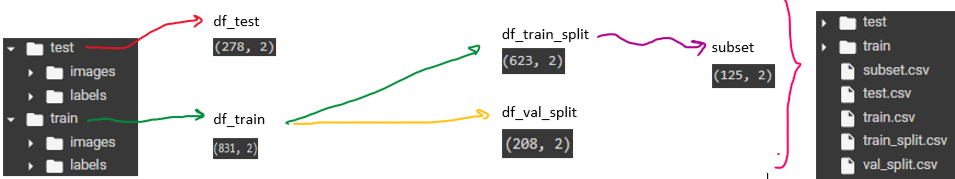

In [ ]:
import pandas as pd
import os

df_train = pd.DataFrame()

nombres_imagenes = os.listdir("/content/train/images")
nombres_etiquetas =[ix_imagen for ix_imagen in os.listdir("/content/train/images")] # en este caso mi referencia es el nombre completo, incluso la extension xq se llaman igual las imagenes a sus labels y son el mismo tipo de archivo.

# aca como los nombres son exactamente iguales , no hacía falta la línea de arriba podía driectamente crear dos columnas con los mismos valores:
# nombres_etiquetas = os.listdir("/content/train/images")


df_train['image_name'] = nombres_imagenes
df_train['label_name'] = nombres_etiquetas

df_train
df_train.shape


(831, 2)

Creo un dataset igual pero para el test

In [ ]:
import pandas as pd

df_test = pd.DataFrame()

nombres_imagenes = os.listdir("/content/test/images")
nombres_etiquetas =[ix_imagen for ix_imagen in os.listdir("/content/test/images")] # en este caso mi referencia es el nombre completo, incluso la extension xq se llaman igual las imagenes a sus labels y son el mismo tipo de archivo.

# aca como los nombres son exactamente iguales , no hacía falta la línea de arriba podía driectamente crear dos columnas con los mismos valores:
# nombres_etiquetas = os.listdir("/content/train/images")


df_test['image_name'] = nombres_imagenes
df_test['label_name'] = nombres_etiquetas

df_test

df_test.shape

(278, 2)

Del df_train, hago un split para tener df_train_split y df_val_split

In [ ]:
from sklearn.model_selection import train_test_split

df_train_split , df_val_split = train_test_split(df_train, test_size = 0.25, shuffle = True, random_state = 42)
# con el validation voy viendo las métricas a medida que entreno

# el test_size (ratio) lo pongo en 1/3 porque sigue mi ratio de train test.
# EN REALIDAD DEBERÍA HABER SIDO 1/4 SIGUIENDO ESTA IDEA PERO SENSIO LO PUSO ASÍ.

# random state está bueno para comparar modelos (es como la seed) siempre que ponga el mismo número
# voy a tener las mismas imágenes de validation.

# stratify me mantiene la proporción de targets. ek 98% de las imágenes 
# de train y validation tienen clase 0 y el 2% restante clase 1
# El stratify lo hago en función de la columna target(por eso se la paso por parám.

df_train_split.shape, df_val_split.shape

((623, 2), (208, 2))

Ahora teniendo esto puedo usar mis dataframes con los nombres ya separados para acceder a los archivos con sus splits de forma ordenada 

In [ ]:
# USO SUBSET de mi split PARA EVALUAR CAMBIOS QUE PIENSO IMPLEMENTAR de forma rápida
_, subset = train_test_split(df_train_split, test_size = 0.2, shuffle = True, random_state = 42)
subset.shape

(125, 2)

In [ ]:
PATH = "/content"
df_train.to_csv(f"{PATH}/train.csv", index = False)
df_test.to_csv(f"{PATH}/test.csv", index = False)
df_train_split.to_csv(f"{PATH}/train_split.csv", index = False)
df_val_split.to_csv(f"{PATH}/val_split.csv", index = False)
subset.to_csv(f"{PATH}/subset.csv", index = False)
# index False para que no me guarde la columna de lo

# Keras baseline:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
#tf.config.run_functions_eagerly(True) 

# https://keras.io/api/applications/ --> ouedo buscar la info de cada red de keras.
# !pip uninstall tensorflow
# !pip install tf-nightly-gpu
tf.__version__

'2.8.2'

In [ ]:
PATH = "/content"
os.listdir(PATH)

['.config',
 'test.csv',
 'val_split.csv',
 'train',
 'drive',
 'train_split.csv',
 'subset.csv',
 'test',
 'train.csv',
 'sample_data']

Voy a usar como train el subset y como val el val_split. Si encuentro algo que va bien, puedo usar el train_split y hasta el train total con el test


In [ ]:

train = pd.read_csv(f"{PATH}/train_split.csv")
val = pd.read_csv(f"{PATH}/val_split.csv")

train.shape, val.shape

((623, 2), (208, 2))

In [ ]:
import numpy as np


BATCH_SIZE = 16 # ese número lo elijo en función de la vram de mi gpu. 
# 16x 39 = 624 --- > 623 train split size
# si uso Batch size de 64, entonces como entreno en 623 datos, cada epoch entrena en 9,35 batches.


def decode(name, label):
    #tf.config.run_functions_eagerly(True)
    img = tf.io.read_file(name) # lee la imágen accediendo al archivo pero sigue siendo texto con los valores de los píxeles
    img = tf.image.decode_png(img, channels=3) # esto sí convierte ese texto en la imágen en sí.
    img = tf.cast(img, tf.float32) #/255 # le paso float32 xq es la precisión que necesita la red neuronal para trabajar bien.

    
    return img,label
    

def load_ds(df): # le paso un df y me devuelve un ds de tf con el PATH de las imágenes y sus target
    imgs_0, labels = df["image_name"].values , df["label_name"].values #son np array: lista con strings de nombres de archivos.
    imgs = [f"{PATH}/train/images/{name}" for name in imgs_0]
     #labels = [f"{PATH}/train/labels/{name}" for name in imgs_0] # pongo 0 xq si no actualizo el valor de imgs arriba y pierdo la referencia

    path_local_drive = "/content/drive/MyDrive/pIASHIBA Proyecto /Datos/Wound Care Center/Labels binary train/labels_bin_npy"
    
    imgs_0_npy= [i.split('.')[0]+".npy" for i in imgs_0] # les saco el .png y lo cambio por .npy

    labels = [f"{path_local_drive}/{name}" for name in imgs_0_npy] 
    labels = [np.load(name) for name in labels]  # ESTO ES CLAVE, YA OBTENGO ACÁ EL ARCHIVO CON SUS VALORES A PARTIR DE LOS PATHS QUE OBTUVE ARRIBA Y USANDO np.load # ABAJO LO CONVIERTO EN TENSOR, ENTONCES EN DECODE NO TENGO Q HACER NADA CON LA LABEL


    ds = tf.data.Dataset.from_tensor_slices((imgs, labels)) #espera un np array (por ahora con strings con los path a los archivos de imágenes reales) y los transforma en tensores. Las label ya estan en npy como las quiero, no hace falta hacerles decode.

    ds = ds.map(decode) 
    ds = ds.shuffle(2048)  
    ds = ds.batch(BATCH_SIZE)
    

    return ds


In [ ]:
train_ds = load_ds(train)
val_ds = load_ds(val)

## Apuntes Entrenamiento del modelo segun paper  (MobileNetV2 + Transfer learning)

Necesito que mi modelo tome como input las imágenes (por batches como tensores) y devuelva tensores con la dimensión de las máscaras de segmentación: (224x224x1) Donde ese 1 es la probabilidad de que el pixel sea blanco o negro.



Debería ser algo así, por el momento no uso esto:
```
IMAGE_SIZE = (224,224,3)
encoder = MobileNetV2(
    include_top = False, # no quiero la última capa xq voy a usar otra. (uso esta pre entrenada pero tb la voy a entrenar con mis miles de imágenes)
    input_shape = IMAGE_SIZE,
    weights = "imagenet"
)
encoder.trainable = False # lo dejo pre entrenado por el momento. Este false hacer que no se apliquen los gradientes que se calcuan cuando haga backprop

inputs = keras.Input(shape = IMAGE_SIZE)

x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = encoder(x, training = False) # le paso la img normalizada y la mando a la mobileNetV2 (diciendole que no calcule gradientes)
x = keras.layers.GlobalAveragePooling2D()(x) 

outputs = keras.layers.Dense(1,activation = "sigmoid")(x) #me conecta todas las salidas a una ÚNICA última neurona xq estoy haciendo clasificación binaria, solo necesito una probabilidad y un threshold
                                                     
model = keras.Model(inputs, outputs)
model.summary()
```



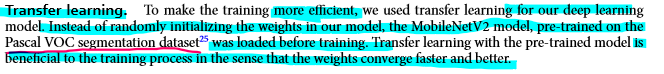

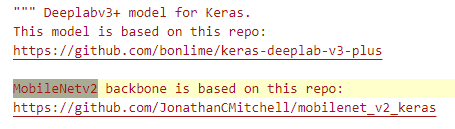

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function

# LINKS DEL CÓDIGO DEL PAPER Y EL DE MOBILENETV2 AL QUE HACEN REFERENCIA
#https://github.dev/uwm-bigdata/wound-segmentation
#https://github.dev/JonathanCMitchell/mobilenet_v2_keras

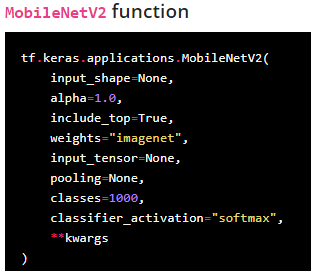

## Entreno el modelo y evalúo (Baseline inicial).

Unet, con backbone de resnet34.

In [ ]:
!pip3 install -U segmentation-models
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'

# Tengo que preprocesar las imágenes según las especificaciones del modelo: img = sm.get_preprocessing(BACKBONE)
#esto ni idea si estará bien así:
#for img in train_ds:
#   img = sm.get_preprocessing(BACKBONE)
 


In [ ]:
model2 = sm.Unet(BACKBONE, encoder_weights = "imagenet")
model2.compile("Adam", loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score])
print(model2.summary()) 

wandb.config = {
  "algorithm": "U-Net",
  "backbone": "resnet34",
  "loss": "bce_jaccard_loss",
  "metrics": "iou_score",
  "learning_rate": 0.001, # Adam tiene por default lr= 0.001
  "epochs": 50,
  "batch_size": 16,
}

In [ ]:

history = model2.fit(train_ds, epochs = 50, validation_data= val_ds, validation_steps = 10, callbacks=[WandbCallback()] )
#TENGO Q CAMBIAR EL VALIDATION STEPS, XQ NO LLEGO A TENER 10 BATCHES, SOLO TENGO 2
# los validation steps tienen q no ser muy altos xq si no no aparecen
history




wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
39/39 [==============================] - 20s 280ms/step - loss: 1.2211 - iou_score: 0.0851 - val_loss: 1.4321 - val_iou_score: 0.0774 - _timestamp: 1655884600.0000 - _runtime: 919.0000
Epoch 2/50
39/39 [==============================] - 10s 229ms/step - loss: 0.8414 - iou_score: 0.2538 - val_loss: 2.1614 - val_iou_score: 0.0322 - _timestamp: 1655884611.0000 - _runtime: 930.0000
Epoch 3/50
39/39 [==============================] - 10s 231ms/step - loss: 0.5106 - iou_score: 0.5348 - val_loss: 560.5345 - val_iou_score: 0.0039 - _timestamp: 1655884620.0000 - _runtime: 939.0000
Epoch 4/50
39/39 [==============================] - 11s 259ms/step - loss: 0.3772 - iou_score: 0.6607 - val_loss: 1.2914 - val_iou_score: 0.0670 - _timestamp: 1655884631.0000 - _runtime: 950.0000
Epoch 5/50
39/39 [==============================] - 11s 255ms/step - loss: 0.3448 - iou_score: 0.6906 - val_loss: 1.1773 - val_iou_score: 0.2170 - _timestamp: 1655884651.0000 - _runtime: 970.0000
Epoch 6/50
39/39 [

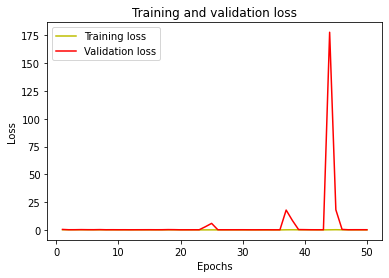

In [ ]:
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

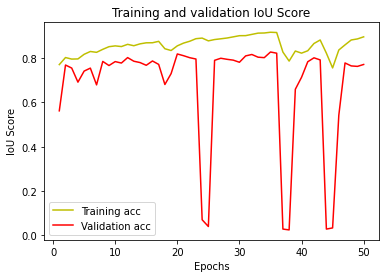

In [ ]:
iou_score = history.history['iou_score']  # estas variables estan en histort.history
val_iou_score = history.history['val_iou_score']  # estas variables estan en histort.history

plt.plot(epochs, iou_score, 'y', label='Training acc')
plt.plot(epochs, val_iou_score, 'r', label='Validation acc')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

### Ahora busco graficar mis predicciones para visualizar cómo funciona mi modelo. Para esto cargo las imágenes de las carpetas, de una forma distinta a como lo hice previamente (para probar nuevos métodos).

Creo una función que reciba una carpeta (con imágenes en un formato legible por cv2.imread) y me devuelve una lista con las imágenes (matrices) de esa carpeta. También puedo pasarle por parámetro una lista con los nomrbes puntuales de los archivos que quiero que carge. Entonces a partir de eso creo X_test y y_test. También lo puedo usar para X_train_split, en lugar de hacerlo de la forma que lo hice antes. Y despeus es muy fácil pasarlo a un array de numpy para ya poder trabajarlo como hice más abajo.

In [ ]:
#!pip install patchify
from patchify import patchify
import tifffile as tiff
import cv2
import os

def cargar_imagenes_filtradas(folder, filename_list = np.array([0])): # si no le paso el 2do parametro, carga todas las que este dentro de la carpeta folder que recibe en el primer parametro
    
    images = []
    if filename_list.all() == 0:
      filename_list = os.listdir(folder)


    for filename in filename_list: # os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # esto lo agego xq si no me la devuelve como negativo, xq cv2 trabaja en BGR en vez de en RGB
        if img is not None:
            images.append(img)
    return images

X_train_split = cargar_imagenes_filtradas("/content/train/images", df_train_split["image_name"]) #


X_test = cargar_imagenes_filtradas("/content/test/images") #
y_test = cargar_imagenes_filtradas("/content/test/labels") 


In [ ]:
X_test = np.array(X_test)
#X_test = np.expand_dims(X_test, -1) #le agrega una dimensión donde le diga
y_test = np.array(y_test)
X_test.shape, y_test.shape

((278, 224, 224, 3), (278, 224, 224, 3))

Chequeo que las X de test coincidan con las y de test

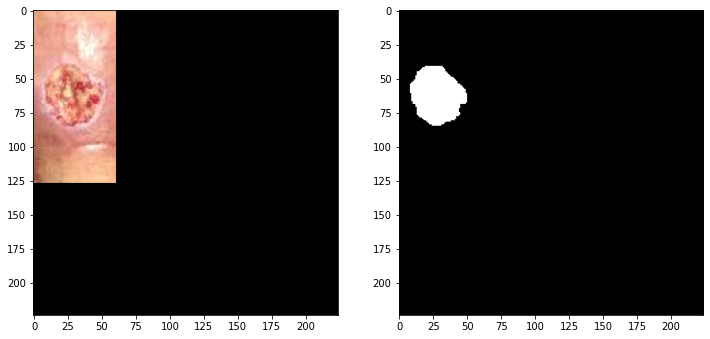

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(y_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((X_test[image_number]))
plt.subplot(122)
plt.imshow((y_test[image_number]))
plt.show()

Calculo el iou para el test set

In [ ]:
y_pred=model2.predict(X_test)
y_pred_thresholded = y_pred > 0.5
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


IoU socre is:  0.7890079677221644


(278, 224, 224, 1)

Grafico algunas predicciones para visualizar el funcionamiento de mi modelo hasta el momento.


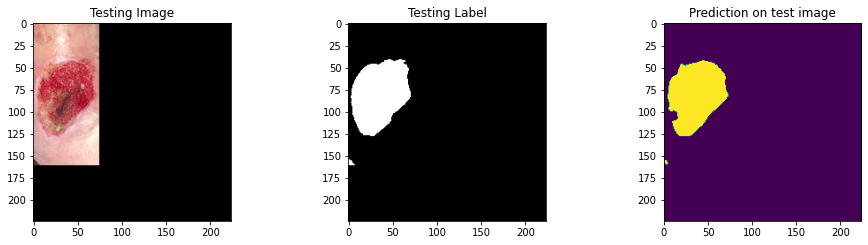

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,:][:,:]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model2.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)


#test_img.shape
#ground_truth.shape
#test_img_norm.shape
#test_img_input.shape
#prediction.shape


image_number = random.randint(0, len(y_test))
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,:])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction) #,cmap='gray')

plt.show()

## Borrador